# Spectral Analysis on Geophysical Data

On the previous notebook we saw the easiest case of spectral analysis (distinct frequencies). Here we will push further the complexity by analysis real wave data. This analysis rely on wave elevation recorded by a buoy of the Costal Data Information Program (CDIP, same dataset used in the [previous notebook](./wave_by_wave_analysis.ipynb)). I made the choice to focus on data collected by the buoy offshore the San Francisco Bay, however, the present notebook can be applied to all the buoys of the program.

Practically speaking, in this Notebook we perform:

 - Download one-dimensional wave data
   
 - Apply window over the signal to remove the spectral leakage

   
 - Perform the Fourier Analysis

   
 - Compute the Power Spectral Density of the signal

   
 - Correct the windowing process, cc Parseval's theorem

   
 - Interpret the wave spectrum


 - Compute the uncertainty of the spectrum

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.stats.distributions import chi2


In [2]:
g = 9.81 #m/sec^2

### The Functions we use for this practical

In [13]:
def create_UTC_axis(ds_xyz, arrayIndex):

    """
    Purpose: Create the time axis associated to the motion along x, y, and z dimension
    ----------
    inputs:
    --------
    ds_xyz: the xarray dataset that contain the motions
    arrayIndex: The array of second
    output:
    --------
    time_array: datetime64 object in s. 
    """
    
    arrayIndex = xr.DataArray(arrayIndex, attrs={'units': 'nb_of_obs'}).astype('timedelta64[s]')

    
    sample_rate_sec = xr.DataArray(ds_xyz.xyzSampleRate.values, attrs={'units': 's'}).astype('timedelta64[s]')
    filter_delay_sec = xr.DataArray(ds_xyz.xyzFilterDelay.values, attrs={'units': 's'}).astype('timedelta64[s]')
    time_axis = xr.DataArray(arrayIndex/sample_rate_sec, attrs={'units': 's'}).astype('timedelta64[s]')

    time_array = ds_xyz.xyzStartTime.values + time_axis - filter_delay_sec
    return time_array

def wave_frequency_spectrum(elevation, Fs = 1.2):
    """
    Purpose: Perform the frequency spectrum of the elevation signal
    ----------
    inputs:
    --------
    elevation: the motion along z (elevation induced by waves)
    Fs: The sampling frequency
    
    output:
    --------
     freq: the frequency axis
     spec_corr: the wave frequency spectrum. _corr stand for correction of the windowing
    """
    
    nfft = len(elevation)  # The number of point for the spectral analysis
    
    Nf = int(nfft/2 + 1)  # The number of frequencies
    # Nf = 200
    df = Fs/nfft  # The spectral resolution
    freq = np.linspace(df, df*(Nf-1), (Nf-1))  # Define the frequency axis

    #########
    # --- The heart of the spectral analysis
    #########
    
    hanningt = 0.5 * (1-np.cos(2*np.pi*np.linspace(0, nfft-1, nfft)/(nfft-1)))  # Hanning window
    wc2t = 1/np.mean(hanningt**2)  # Correction factor
    Zw = (elevation-np.mean(elevation)) * hanningt  # Apply the window to avoid spectral leakage (put to 0 the extrema) + detrend
    Zf = np.fft.fft(Zw, nfft, axis = 0)/nfft  # Apply the Fourier Transform
    spec = abs(Zf)**2 / df  # Compute the power spectral density
    spec_folded = 2 * spec[1:Nf]

    spec_corr =  spec_folded * wc2t  # Correct the spectrum
    return freq, spec_corr, spec_folded, Zw


def wave_frequency_spectrum_overlap(elevation, overlap, nfft,  Fs = 1.2):

    """
    Purpose: Perform the frequency spectrum of the elevation signal with the signal cut in segments with overlap
    ----------
    inputs:
    --------
    elevation: the motion along z (elevation induced by waves)
    overlap: the overlap between segments in %
    nfft: tthe number of point per segments
    Fs: The sampling frequency
    
    output:
    --------
     freq: the frequency axis
     spec_corr_mean: the mean wave frequency spectrum. _corr stand for correction of the windowing
    """  
    Nf = int(nfft/2 + 1) # The number of frequencies
    NS1 = len(elevation)//nfft # The number point per segment
    ov = overlap/100 # percentage of overlap between segments
    NS = NS1 * (1 + 2*ov) - 2 * ov # number of point per segment
    
    Eh = np.ones((int(NS), 1)) # Initialize array of NS pts
    hanningt = 0.5 * (1-np.cos(2*np.pi*np.linspace(0, nfft-1, nfft)/(nfft-1))) # Hanning window

    H = hanningt * Eh # 1d window
    elevmat = np.zeros((nfft, int(NS))) # initialize matrix of length of spectrum times n_seg
    vec_i = np.arange(0, NS, 1)
    print(f'We chunk the signal into {int(NS)} windows')

    df = Fs/nfft # frequency resolution
    # freq = np.linspace(df, df*(Nf-1), (Nf - 1)) # frequency axis

    for iw in range(len(vec_i)): # fill matrix of sub sample
        nstart = np.floor((iw-1+1)*(1 - ov) * nfft)
        nend = nstart + nfft
        elevmat[:, iw] = elevation[int(nstart):int(nend)]

    Nf2 = len(elevmat[:, -1])//2 # I take the last window, but any one work
    freq = np.linspace(df, df*(Nf2-1), (Nf2)) # frequency axis

    elevmat2 = elevmat.T
    
    wc2t = 1/np.mean(hanningt**2) # correction factor
    Zw = (elevmat2-np.mean(elevmat2)) * hanningt # Windowed signals + remove trend

    Zf = np.fft.fft(Zw, nfft, axis = 1)/nfft # Fourier transform of the windowed signals, normalized by the number of point used

    spec = abs(Zf)**2  / (df) # Power spectral density of the spectra
    spec_folded = 2 * spec[:, 0:np.size(spec, axis = 1)//2] # Fold the spectrum
    spec_corr = spec_folded * wc2t # correct the spectrum because of window
    spec_corr_mean = np.mean(spec_corr, axis = 0).T # mean spectrum

    return freq, spec_corr_mean, spec_folded

### Load data

In [4]:
file_url_data = './data/motion_wave_data_cdip.nc'
file_url_param = './data/spectral_wave_data_cdip.nc'

ds_buoy = xr.open_dataset(file_url_data)
ds_operationel = xr.open_dataset(file_url_param)

n_data = 3000 # there are 100_000 surface elevation data, we load 3000 of them

arrayIndex = np.linspace(0, n_data, n_data) # an array of ~ 30 min
time_UTC = create_UTC_axis(ds_buoy, arrayIndex)
elevation =  ds_buoy.xyzZDisplacement[:len(arrayIndex)] # work on a 30 min window

In [11]:
ds_operationel

<xarray.Dataset>
Dimensions:                     (sourceCount: 1951, waveTime: 1950, metaBoundsCount: 2, waveFrequency: 64, sstTime: 1950, gpsTime: 1950, dwrTime: 1950)
Coordinates:
  * waveTime                    (waveTime) datetime64[ns] 2025-09-06T22:00:00...
  * waveFrequency               (waveFrequency) float32 0.025 0.03 ... 0.57 0.58
  * sstTime                     (sstTime) datetime64[ns] 2025-09-06T22:28:20 ...
  * gpsTime                     (gpsTime) datetime64[ns] 2025-09-06T22:21:00 ...
  * dwrTime                     (dwrTime) datetime64[ns] 2025-09-06T22:00:00 ...
    metaDeployLatitude          float32 ...
    metaDeployLongitude         float32 ...
Dimensions without coordinates: sourceCount, metaBoundsCount
Data variables: (12/51)
    sourceFilename              (sourceCount) object ...
    waveTimeBounds              (waveTime, metaBoundsCount) datetime64[ns] ...
    waveFlagPrimary             (waveTime) float32 ...
    waveFlagSecondary           (waveTime) float32 ...
    waveHs                      (waveTime) float32 ...
    waveTp                      (waveTime) float32 ...
    ...                          ...
    metaStationName             |S28 ...
    metaPlatform                |S1 ...
    metaInstrumentation         |S1 ...
    metaWaterDepth              float32 ...
    metaDeclination             float32 ...
    metaGridMapping             |S1 ...
Attributes: (12/66)
    naming_authority:                edu.ucsd.cdip
    keywords_vocabulary:             Global Change Master Directory (GCMD) Ea...
    date_created:                    2025-10-17T16:30:22Z
    date_issued:                     2025-10-17T16:30:22Z
    date_modified:                   2025-10-17T16:30:22Z
    creator_name:                    Coastal Data Information Program, SIO/UCSD
    ...                              ...
    time_coverage_resolution:        PT30M
    source:                          insitu observations
    instrument:                      metaInstrumentation
    platform:                        wave_buoy
    platform_vocabulary:             http://mmisw.org/ont/ioos/platform
    platform_name:                   POINT REYES, CA BUOY - 029p1

In [10]:
ds_buoy

<xarray.Dataset>
Dimensions:              (sourceCount: 100000, xyzCount: 4506794)
Coordinates:
    metaDeployLatitude   float32 ...
    metaDeployLongitude  float32 ...
Dimensions without coordinates: sourceCount, xyzCount
Data variables: (12/16)
    sourceFilename       (sourceCount) object ...
    xyzStartTime         datetime64[ns] 2025-09-06T22:00:00
    xyzSampleRate        float64 1.28
    xyzFilterDelay       float64 133.3
    xyzFlagPrimary       (xyzCount) float32 ...
    xyzFlagSecondary     (xyzCount) float32 ...
    ...                   ...
    metaStationName      |S28 ...
    metaPlatform         |S1 ...
    metaInstrumentation  |S1 ...
    metaWaterDepth       float32 ...
    metaDeclination      float32 ...
    metaGridMapping      |S1 ...
Attributes: (12/66)
    naming_authority:                edu.ucsd.cdip
    keywords_vocabulary:             Global Change Master Directory (GCMD) Ea...
    date_created:                    2025-10-17T16:31:11Z
    date_issued:                     2025-10-17T16:31:11Z
    date_modified:                   2025-10-17T16:31:11Z
    creator_name:                    Coastal Data Information Program, SIO/UCSD
    ...                              ...
    time_coverage_resolution:        PT0.78S
    source:                          insitu observations
    instrument:                      metaInstrumentation
    platform:                        wave_buoy
    platform_vocabulary:             http://mmisw.org/ont/ioos/platform
    platform_name:                   POINT REYES, CA BUOY - 029p1

In [5]:
dt = time_UTC[-1] - time_UTC[0]

# Convert to total minutes
total_minutes = dt / np.timedelta64(1, 'm')
# Compute hours and minutes
hours = int(total_minutes // 60)
minutes = int(total_minutes % 60)

print(f"The duration of the record is of {hours} hours {minutes} minutes")

The duration of the record is of 0 hours 50 minutes


In [6]:
ds_operation_sel = ds_operationel.sel(waveTime = slice(time_UTC[0], time_UTC[-1])) # Select a record length of n_data obs.

In [7]:
mean_spec_operational = ds_operation_sel.waveEnergyDensity.mean(dim = 'waveTime') # get the mean reference spectrum

In [8]:
fmax = ds_operationel.waveFrequency.max().values # get the highest frequency in the reference Dataset
fs = 2*fmax # the sampling frequency is twice the highest frequency resolved in the reference dataset (Nyquist)

### The wave elevation signal. The signal we are processing.

Text(0, 0.5, 'Wave Amplitude [m]')

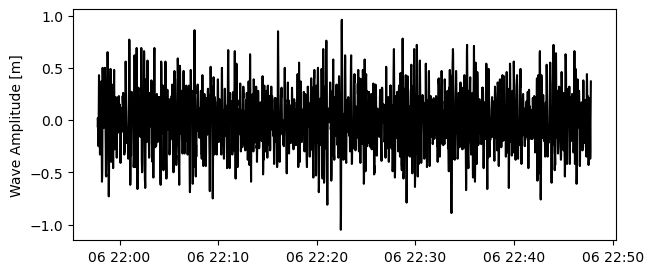

In [12]:
fig, ax = plt.subplots(figsize = (7, 3))
ax.plot(time_UTC, elevation, color = 'k')
ax.set_ylabel('Wave Amplitude [m]')

Text(0, 0.5, 'Wave Amplitude [m]')

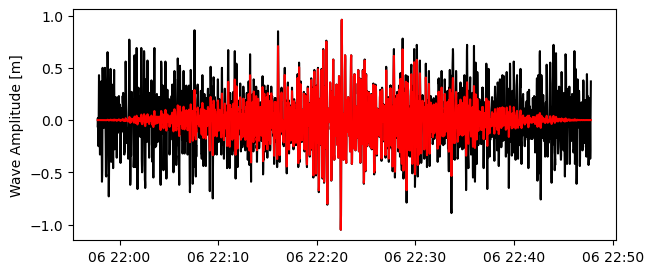

In [16]:
fig, ax = plt.subplots(figsize = (7, 3))
ax.plot(time_UTC, elevation, color = 'k')
ax.plot(time_UTC, Zw, color = 'r')

ax.set_ylabel('Wave Amplitude [m]')

The H_1/3 is equal to 1.2170000076293945 m


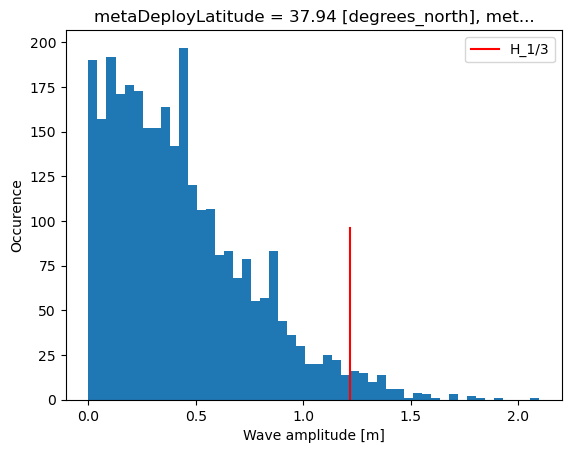

In [10]:
counts, bins = np.histogram(2*abs((elevation[elevation>0].values)), bins = 50)
cdf = np.cumsum(counts) # the cumulative density function
cdf = cdf / cdf[-1]  # normalize to [0, 1]
idx = np.searchsorted(cdf, 2/3)  # lower bound of highest 1/3 waves
H_1_3 = np.nanmean(bins[idx:])
print(f'The H_1/3 is equal to {H_1_3} m')


fig, ax = plt.subplots()
# for simplicity I assume the crest and the trough as symmetric, which is not true!
(2*abs(elevation)).plot.hist(ax = ax, bins = 50)
plt.plot([np.mean(bins[idx:]), np.mean(bins[idx:])], [0, counts.max()], color = 'r', label = 'H_1/3')
ax.set_xlabel('Wave amplitude [m]')
ax.set_ylabel('Occurence')
ax.legend()

In [ ]:
Hs = 4 * np.var()##### the significant wave height

In [15]:
freq_raw, spec_raw, spec_uncorrected_raw, Zw = wave_frequency_spectrum(elevation.values, ds_buoy.xyzSampleRate.values) # The raw spectral analysis
# freq_smooth, spec_corr_mean, spec_uncorrected = wave_frequency_spectrum_overlap(elevation.values, 50, 150,  Fs = ds_buoy.xyzSampleRate.values) # The Welch Method

This method of chunk the total signal into sub-signal is called the Welch's method. Don't forget to window all the chunks to avoid spectral leakage.

In [ ]:
Hs_no_cor =  ###### The significant wave heigth from spectral data (from data in the Fourier space)
Hs_corrected =  ###### The significant wave heigth from spectral data (from data in the Fourier space)

### Plots the Spectra:
 - 1 The spectrum without segmentation
 - 2 The spectrum with segmentation (Welch method)
 - 3 The reference spectrum from CDIP

Text(0.5, 1.0, '')

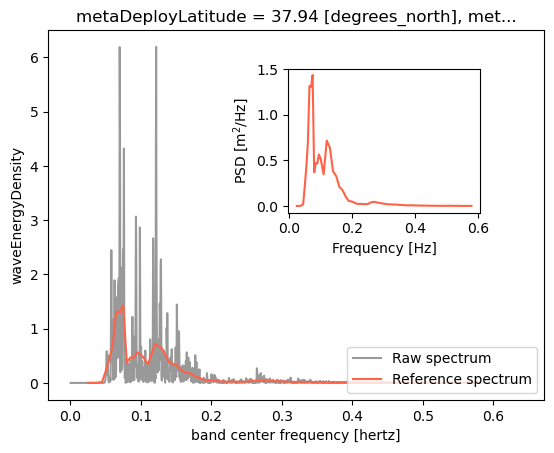

In [15]:
fig, ax = plt.subplots()
ax_inset = fig.add_axes([.5, .5, .3, .3])
ax.plot(freq_raw, spec_raw, color = 'k', alpha = .4, label = 'Raw spectrum')

# ax.plot(freq_smooth, spec_corr_mean, color = 'teal', label = 'Filtered spectrum')
mean_spec_operational.plot(ax = ax, color = 'tomato', label = 'Reference spectrum')
ax.legend(loc = 4)
# ax_inset.plot(freq_smooth, spec_corr_mean, color = 'teal')
mean_spec_operational.plot(ax = ax_inset, color = 'tomato')
ax_inset.set_xlabel('Frequency [Hz]')
ax_inset.set_ylabel('PSD [m$^2$/Hz]')
ax_inset.set_title('')

### Wave characteristics: let's spot the dominant wave frequencies (periods) and the significant wave height

In [16]:
peaks_spectrum = find_peaks(spec_corr_mean, height = .05, width = 1)[0] # here, the height and width threshold are ONLY applicable for this record 

df = np.gradient(freq_smooth) # the frequency step

# hs_raw = ########## with spec_raw
# hs_spec = ########## with spec_uncorrected_raw
hs_ope = ds_operation_sel.waveHs.mean(dim = 'waveTime').values


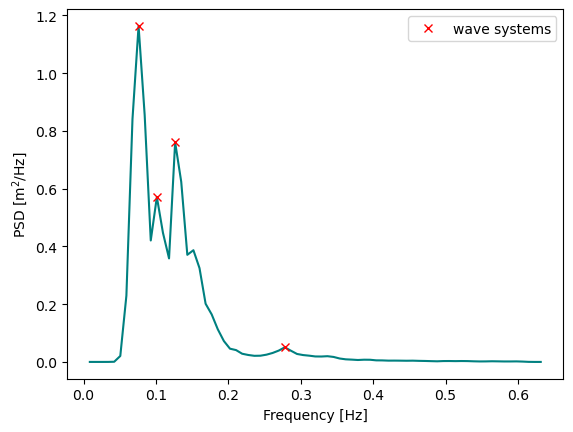

In [17]:
plt.plot(freq_smooth, spec_corr_mean,color = 'teal')
plt.plot(freq_smooth[peaks_spectrum], spec_corr_mean[peaks_spectrum], marker= 'x', lw = 0, color = 'r', label = 'wave systems')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [m$^2$/Hz]')
omega_wave_system_one =  2*np.pi*freq_smooth[peaks_spectrum][0]
omega_wave_system_two =  2*np.pi*freq_smooth[peaks_spectrum][1]
omega_wave_system_three =  2*np.pi*freq_smooth[peaks_spectrum][2]
omega_wave_system_four =  2*np.pi*freq_smooth[peaks_spectrum][3]

# wavelengths = ##########
# phase_speeds = ##########

### Uncertainties

As with any mean of random variables (in this case, spectra), the resulting mean spectrum is associated with an uncertainty. More precisely, the mean corresponds to the average of a variance. According to Cochran’s theorem, the sample variance follows a $\chi^{2}$ distribution with N degrees of freedom. Based on Gaussian statistics, the upper and lower 95% confidence bounds for the spectral density, $\mathrm{PSD}(f)$, are determined from the corresponding quantiles of the $\chi^{2}$ distribution.

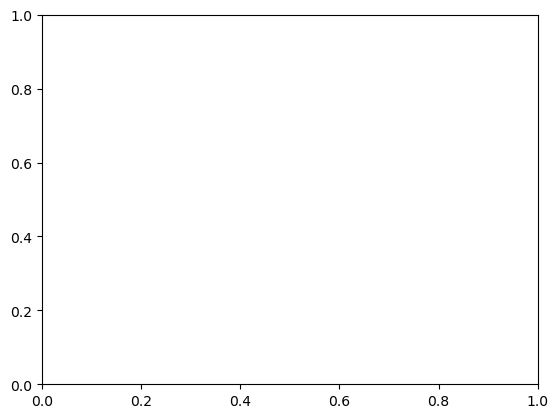

In [27]:
fig, ax = plt.subplots()
######